In [1]:
import ee
import geopandas as gpd
from src.data import gedi_pipeline
from src.data.ee import lcms_import
from src.processing.regen import regen_analysis
from src.data.fire_perimeters import FirePerimeters, FirePerimetersDB, Fire, match_gedi_to_raster, FireRastersDB
from src.data import fire_perimeters
from src.data import gedi_raster_matching
from src.data import raster
import rasterio as rio
import matplotlib.pyplot as plt
import pandas as pd
from src.constants import DATA_PATH, USER_PATH
from fitter import Fitter, get_common_distributions, get_distributions
import seaborn as sns
from fastai.tabular.all import save_pickle, load_pickle
from src.visualization.dists import plot_pdf
from src.data import gedi_pipeline
import seaborn as sns
import numpy as np

sns.set_theme()

import importlib
importlib.reload(regen_analysis)
importlib.reload(gedi_pipeline)
importlib.reload(gedi_raster_matching)
importlib.reload(raster)
importlib.reload(fire_perimeters)

2023-06-26 08:07:53,332 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_pipeline.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2023-06-26 08:07:53,335 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_raster_matching.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2023-06-26 08:07:53,336 DEBUG: Logger /home/jk871/fire-regen/src/data/fire_perimeters.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


<module 'src.data.fire_perimeters' from '/home/jk871/fire-regen/src/data/fire_perimeters.py'>

In [2]:
gedi_ndvi = load_pickle("/maps/fire-regen/data/gedi_ndvi_timeseries_jun_26.pkl")

In [3]:
gedi_ndvi_pft = gedi_ndvi[gedi_ndvi.pft_class == 1]

In [4]:
gedi_ndvi = gedi_ndvi_pft.astype({'burn_year': 'int32', 'severity': 'int32'})

In [5]:
gedi_ndvi = gedi_ndvi.astype({'burn_year': 'int32', 'severity': 'category'})

In [6]:
gedi_ndvi['severity'] = gedi_ndvi.severity.cat.set_categories(["Low", "Medium", "High"], True, True)

In [42]:
gedi_ndvi = gedi_ndvi.astype({'time_since_burn': 'int32'})

### Plot NDVI time series for different burn years 

In [48]:
new_df = pd.melt(gedi_ndvi, id_vars=["severity", "burn_year"], value_vars=[str(x) for x in range(-10, 35)])
new_df

,severity,burn_year,variable,value
0,2,1985,-10,NaN
1,2,1985,-10,NaN
2,2,1985,-10,NaN
3,2,1985,-10,NaN
4,3,1985,-10,NaN
...,...,...,...,...
14985940,2,2020,34,NaN
14985941,3,2020,34,NaN
14985942,2,2020,34,NaN
14985943,4,2020,34,NaN


In [49]:
new_df[new_df.burn_year.isin(range(1988, 1993))].head(100)

,severity,burn_year,variable,value
13477,4,1988,-10,NaN
13478,4,1988,-10,NaN
13479,4,1988,-10,NaN
13480,4,1988,-10,NaN
13481,4,1988,-10,NaN
...,...,...,...,...
13572,4,1988,-10,NaN
13573,2,1988,-10,NaN
13574,4,1988,-10,NaN
13575,4,1988,-10,NaN


In [50]:
new_df.variable.unique()

array(['-10', '-9', '-8', '-7', '-6', '-5', '-4', '-3', '-2', '-1', '0',
       '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34'],
      dtype=object)

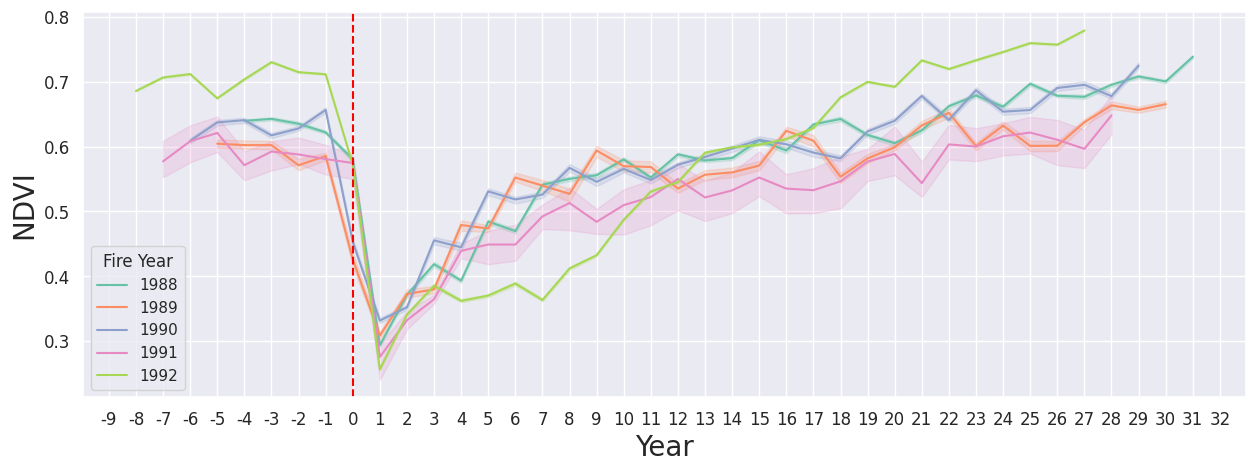

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.lineplot(new_df[new_df.burn_year.isin(range(1988, 1993))], x="variable", y="value", hue="burn_year", ax=ax, palette="Set2", estimator="median")
ax.set_ylabel("NDVI", fontsize=20)
ax.set_xlabel("Year", fontsize=20)
ax.tick_params(axis="both", labelsize=12)
ax.axvline('0', color="red", linestyle='--')
ax.legend(title='Fire Year')

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
sns.lineplot(new_df[new_df.burn_year.isin(range(1988, 1993))], x="variable", y="value", hue="burn_year", ax=ax[0], palette="Set2", estimator="median")
ax[0].set_ylabel("NDVI", fontsize=20)
ax[0].set_xlabel("Year", fontsize=20)
ax[0].tick_params(axis="both", labelsize=12)
ax[0].axvline('0', color="red", linestyle='--')
ax[0].legend(title='Fire Year')

sns.lineplot(new_df[new_df.burn_year.isin(range(2000, 2005))], x="variable", y="value", hue="burn_year", ax=ax[1], palette="Set2", estimator="median")
ax[1].set_ylabel("NDVI", fontsize=20)
ax[1].set_xlabel("Year", fontsize=20)
ax[1].tick_params(axis="both", labelsize=12)
ax[1].axvline('0', color="red", linestyle='--')
ax[1].legend(title='Fire Year')

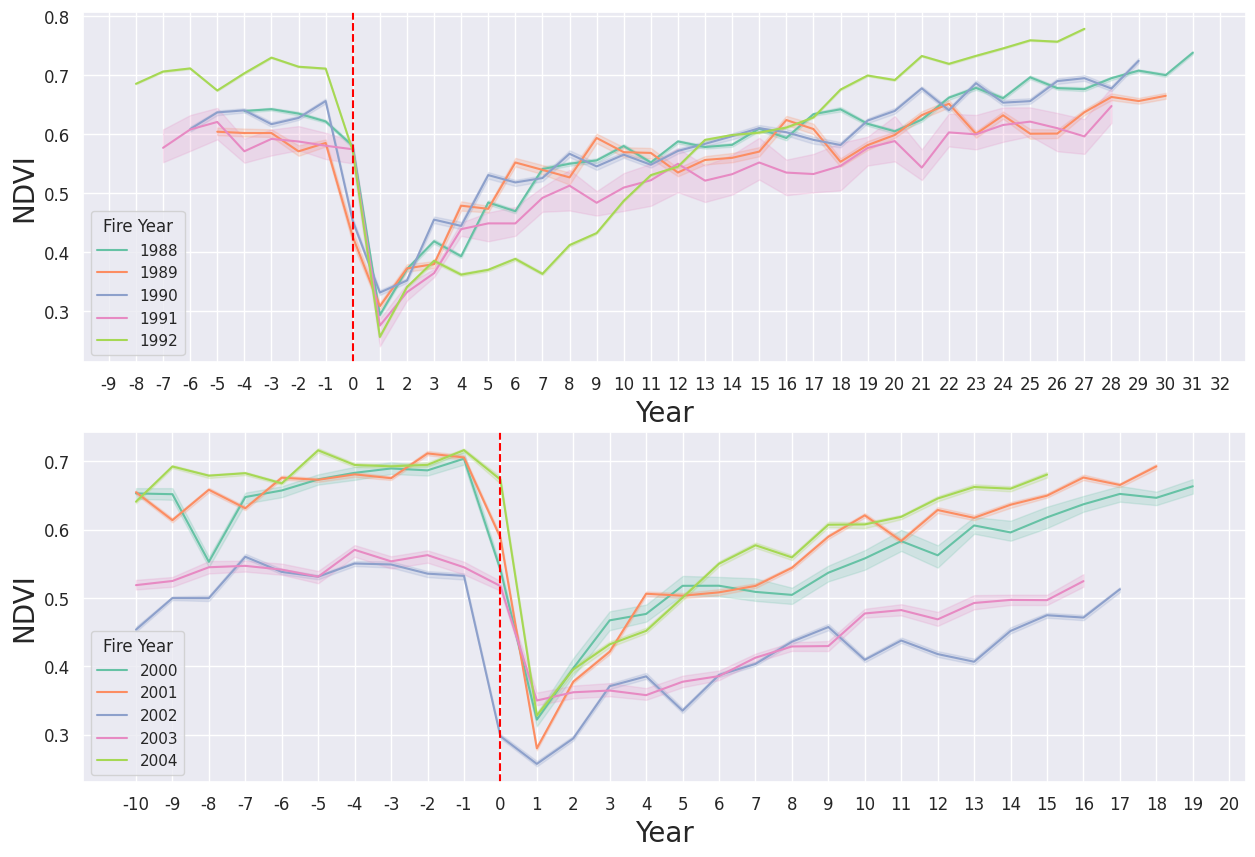

In [34]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
sns.lineplot(new_df[new_df.burn_year.isin(range(1988, 1993))], x="variable", y="value", hue="burn_year", ax=ax[0], palette="Set2", estimator="median")
ax[0].set_ylabel("NDVI", fontsize=20)
ax[0].set_xlabel("Year", fontsize=20)
ax[0].tick_params(axis="both", labelsize=12)
ax[0].axvline('0', color="red", linestyle='--')
ax[0].legend(title='Fire Year')

sns.lineplot(new_df[new_df.burn_year.isin(range(2000, 2005))], x="variable", y="value", hue="burn_year", ax=ax[1], palette="Set2", estimator="median")
ax[1].set_ylabel("NDVI", fontsize=20)
ax[1].set_xlabel("Year", fontsize=20)
ax[1].tick_params(axis="both", labelsize=12)
ax[1].axvline('0', color="red", linestyle='--')
ax[1].legend(title='Fire Year')

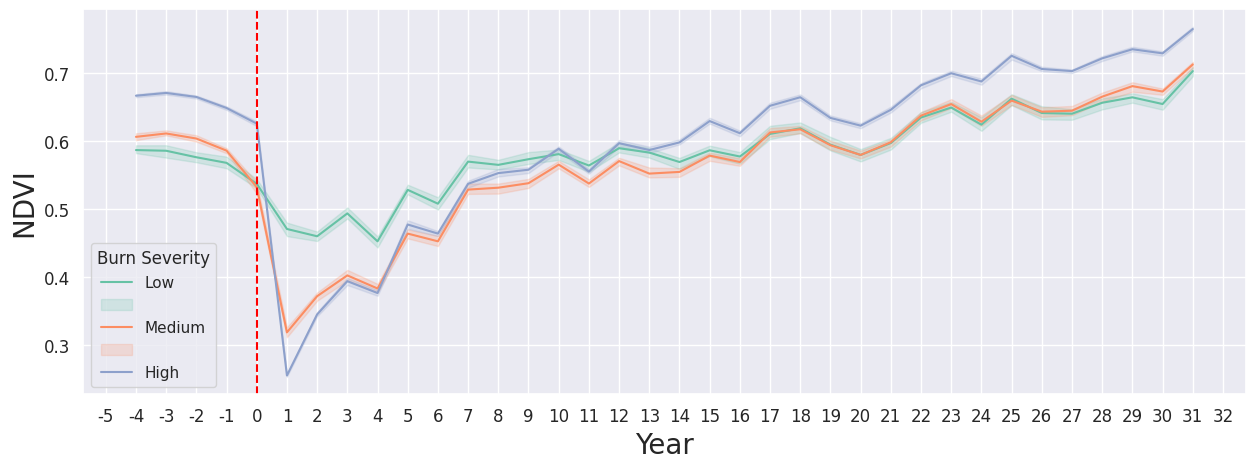

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.lineplot(new_df[new_df.burn_year.isin(range(1988, 1989))], x="variable", y="value", hue="severity", ax=ax, palette="Set2", estimator="median")
ax.set_ylabel("NDVI", fontsize=20)
ax.set_xlabel("Year", fontsize=20)
ax.tick_params(axis="both", labelsize=12)
ax.axvline('0', color="red", linestyle='--')
ax.legend(['Low', '', 'Medium', '', 'High'], title='Burn Severity')

### NDVI Recovery Stats

In [7]:
# Raw value should be df[-1] - df[1]
gedi_ndvi['ndvi_fire_loss_raw'] = gedi_ndvi["-1"] - gedi_ndvi["1"]
gedi_ndvi['ndvi_fire_loss_rel'] = (gedi_ndvi["-1"] - gedi_ndvi["1"]) / gedi_ndvi["-1"]

In [8]:
for i in range(1, 35):
    gedi_ndvi[f'{i}_rel'] = gedi_ndvi[f"{i}"] / gedi_ndvi["-1"]

In [9]:
print(gedi_ndvi['1_rel'].mean())
print(gedi_ndvi['5_rel'].mean())
print(gedi_ndvi['10_rel'].mean())
print(gedi_ndvi['15_rel'].mean())
print(gedi_ndvi['20_rel'].mean())
print(gedi_ndvi['25_rel'].mean())
print(gedi_ndvi['30_rel'].mean())
print(gedi_ndvi['34_rel'].mean())

0.5808521635149536
0.7482280118050673
0.8498383302106916
0.9089497519960298
0.9781521865576622
1.0459253630646663
1.0710740673856531
1.1547452298110739


In [10]:
gedi_ndvi.groupby("severity").mean(numeric_only=True)[['1_rel', '5_rel', '10_rel', '15_rel', '20_rel', '25_rel', '30_rel', '34_rel']]

,1_rel,5_rel,10_rel,15_rel,20_rel,25_rel,30_rel,34_rel
severity,,,,,,,,
Low,0.795811,0.863815,0.935749,0.965838,1.011777,1.046320,1.077413,1.180836
Medium,0.570976,0.751371,0.867300,0.918562,0.976824,1.036921,1.061207,1.092240
High,0.390875,0.657685,0.784009,0.872067,0.959750,1.050748,1.074738,1.041374


### NDVI Space for Time

In [25]:
gedi_ndvi[["gedi_year", "burn_year", "time_since_burn"]]

,gedi_year,burn_year,time_since_burn
0,2020,1985,35.0
1,2022,1985,37.0
4,2019,1985,34.0
5,2020,1985,35.0
7,2019,1985,34.0
...,...,...,...
404823,2022,2020,2.0
404824,2022,2020,2.0
404825,2022,2020,2.0
404826,2021,2020,1.0


In [26]:
gedi_ndvi.gedi_year.unique()

array([2020, 2022, 2019, 2021], dtype=int32)

In [ ]:
gedi_ndvi.rename(columns={"NDVI_mean" : "ndvi_2020"})

In [27]:
for year in range(2019, 2023):
    raster = gedi_raster_matching.get_landsat_raster_sampler(int(year))
    gedi_ndvi = gedi_raster_matching.sample_raster(raster, gedi_ndvi, kernel=3)
    gedi_ndvi = gedi_ndvi.rename(columns={"NDVI_mean" : f"ndvi_{year}"})

In [28]:
for year in range(2019, 2023):
    gedi_ndvi[f"rel_NDVI_{year}"] = gedi_ndvi[f"ndvi_{year}"] / gedi_ndvi["-1"]

In [29]:
for year in range(2019, 2023):
    gedi_ndvi.loc[gedi_ndvi['gedi_year'] == year, 'rel_NDVI'] = gedi_ndvi[gedi_ndvi['gedi_year'] == year][f"rel_NDVI_{year}"]

In [32]:
for year in range(2019, 2023):
    gedi_ndvi.loc[gedi_ndvi['gedi_year'] == year, 'NDVI_mean'] = gedi_ndvi[gedi_ndvi['gedi_year'] == year][f"ndvi_{year}"]

In [31]:
gedi_ndvi[['gedi_year', "rel_NDVI", 'rel_NDVI_2020', 'rel_NDVI_2021', 'rel_NDVI_2022', 'rel_NDVI_2019']]

,gedi_year,rel_NDVI,rel_NDVI_2020,rel_NDVI_2021,rel_NDVI_2022,rel_NDVI_2019
0,2020,1.115119,1.115119,1.133102,1.082971,1.264812
1,2022,1.118221,1.150031,1.159955,1.118221,1.274111
4,2019,1.240449,1.049214,1.092548,1.051092,1.240449
5,2020,1.099211,1.099211,1.117777,1.067332,1.256892
7,2019,1.295204,1.177124,1.216321,1.139761,1.295204
...,...,...,...,...,...,...
404823,2022,0.590146,0.791073,0.579591,0.590146,1.000000
404824,2022,0.547046,0.671420,0.439451,0.547046,1.000000
404825,2022,0.611299,0.854786,0.615183,0.611299,1.000000
404826,2021,0.384988,0.967416,0.384988,0.393366,1.000000


In [13]:
gedi_ndvi["rel_NDVI"] = gedi_ndvi["NDVI_mean"] / gedi_ndvi["-1"]

In [14]:
gedi_ndvi["time_since_burn_ndvi"] = 2020 - gedi_ndvi["burn_year"]

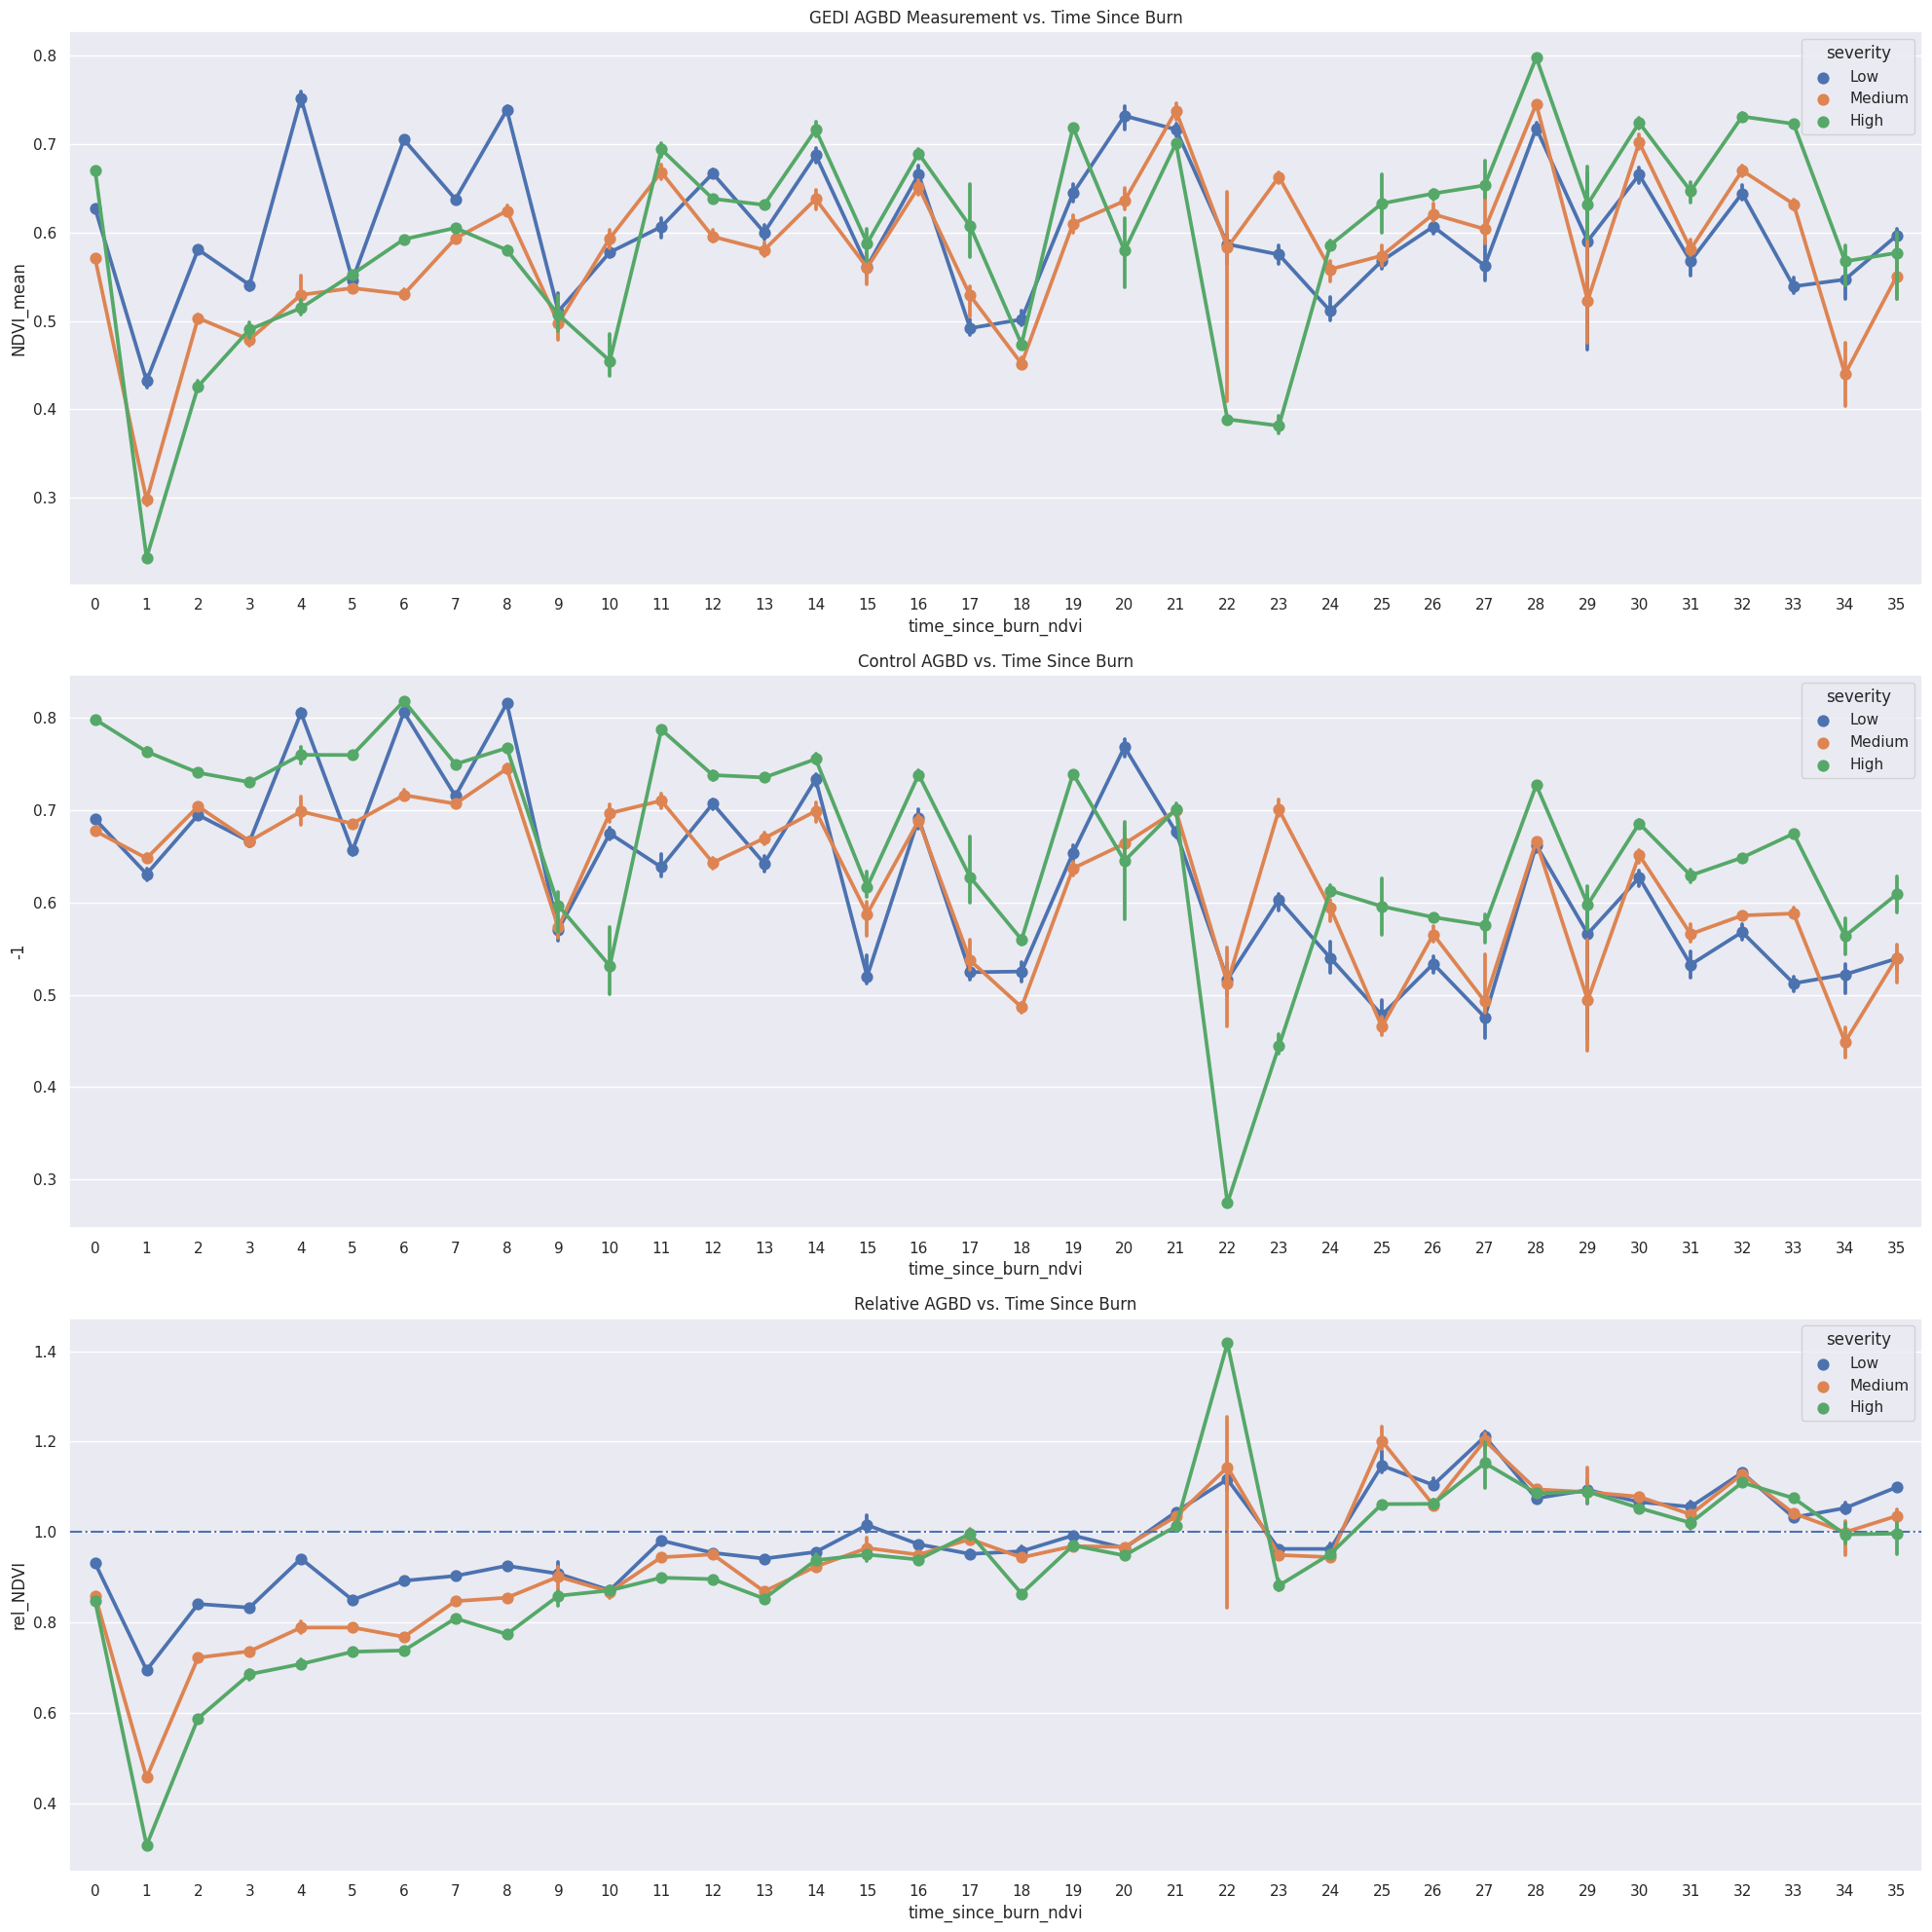

In [15]:
fig, ax = plt.subplots(3, 1, figsize=(20, 20))
sns.pointplot(gedi_ndvi, x='time_since_burn_ndvi', y='NDVI_mean', hue='severity', estimator='median', ax=ax[0])
sns.pointplot(gedi_ndvi, x='time_since_burn_ndvi', y='-1', hue='severity', estimator='median', ax=ax[1])
sns.pointplot(gedi_ndvi, x='time_since_burn_ndvi', y='rel_NDVI', hue='severity', estimator='median', ax=ax[2])
ax[2].axhline(y=1, linestyle="-.")

ax[0].set_title("GEDI AGBD Measurement vs. Time Since Burn")
ax[1].set_title("Control AGBD vs. Time Since Burn")
ax[2].set_title("Relative AGBD vs. Time Since Burn")

#ax[2].set_ylim((0.5, 1.3))
fig.tight_layout()

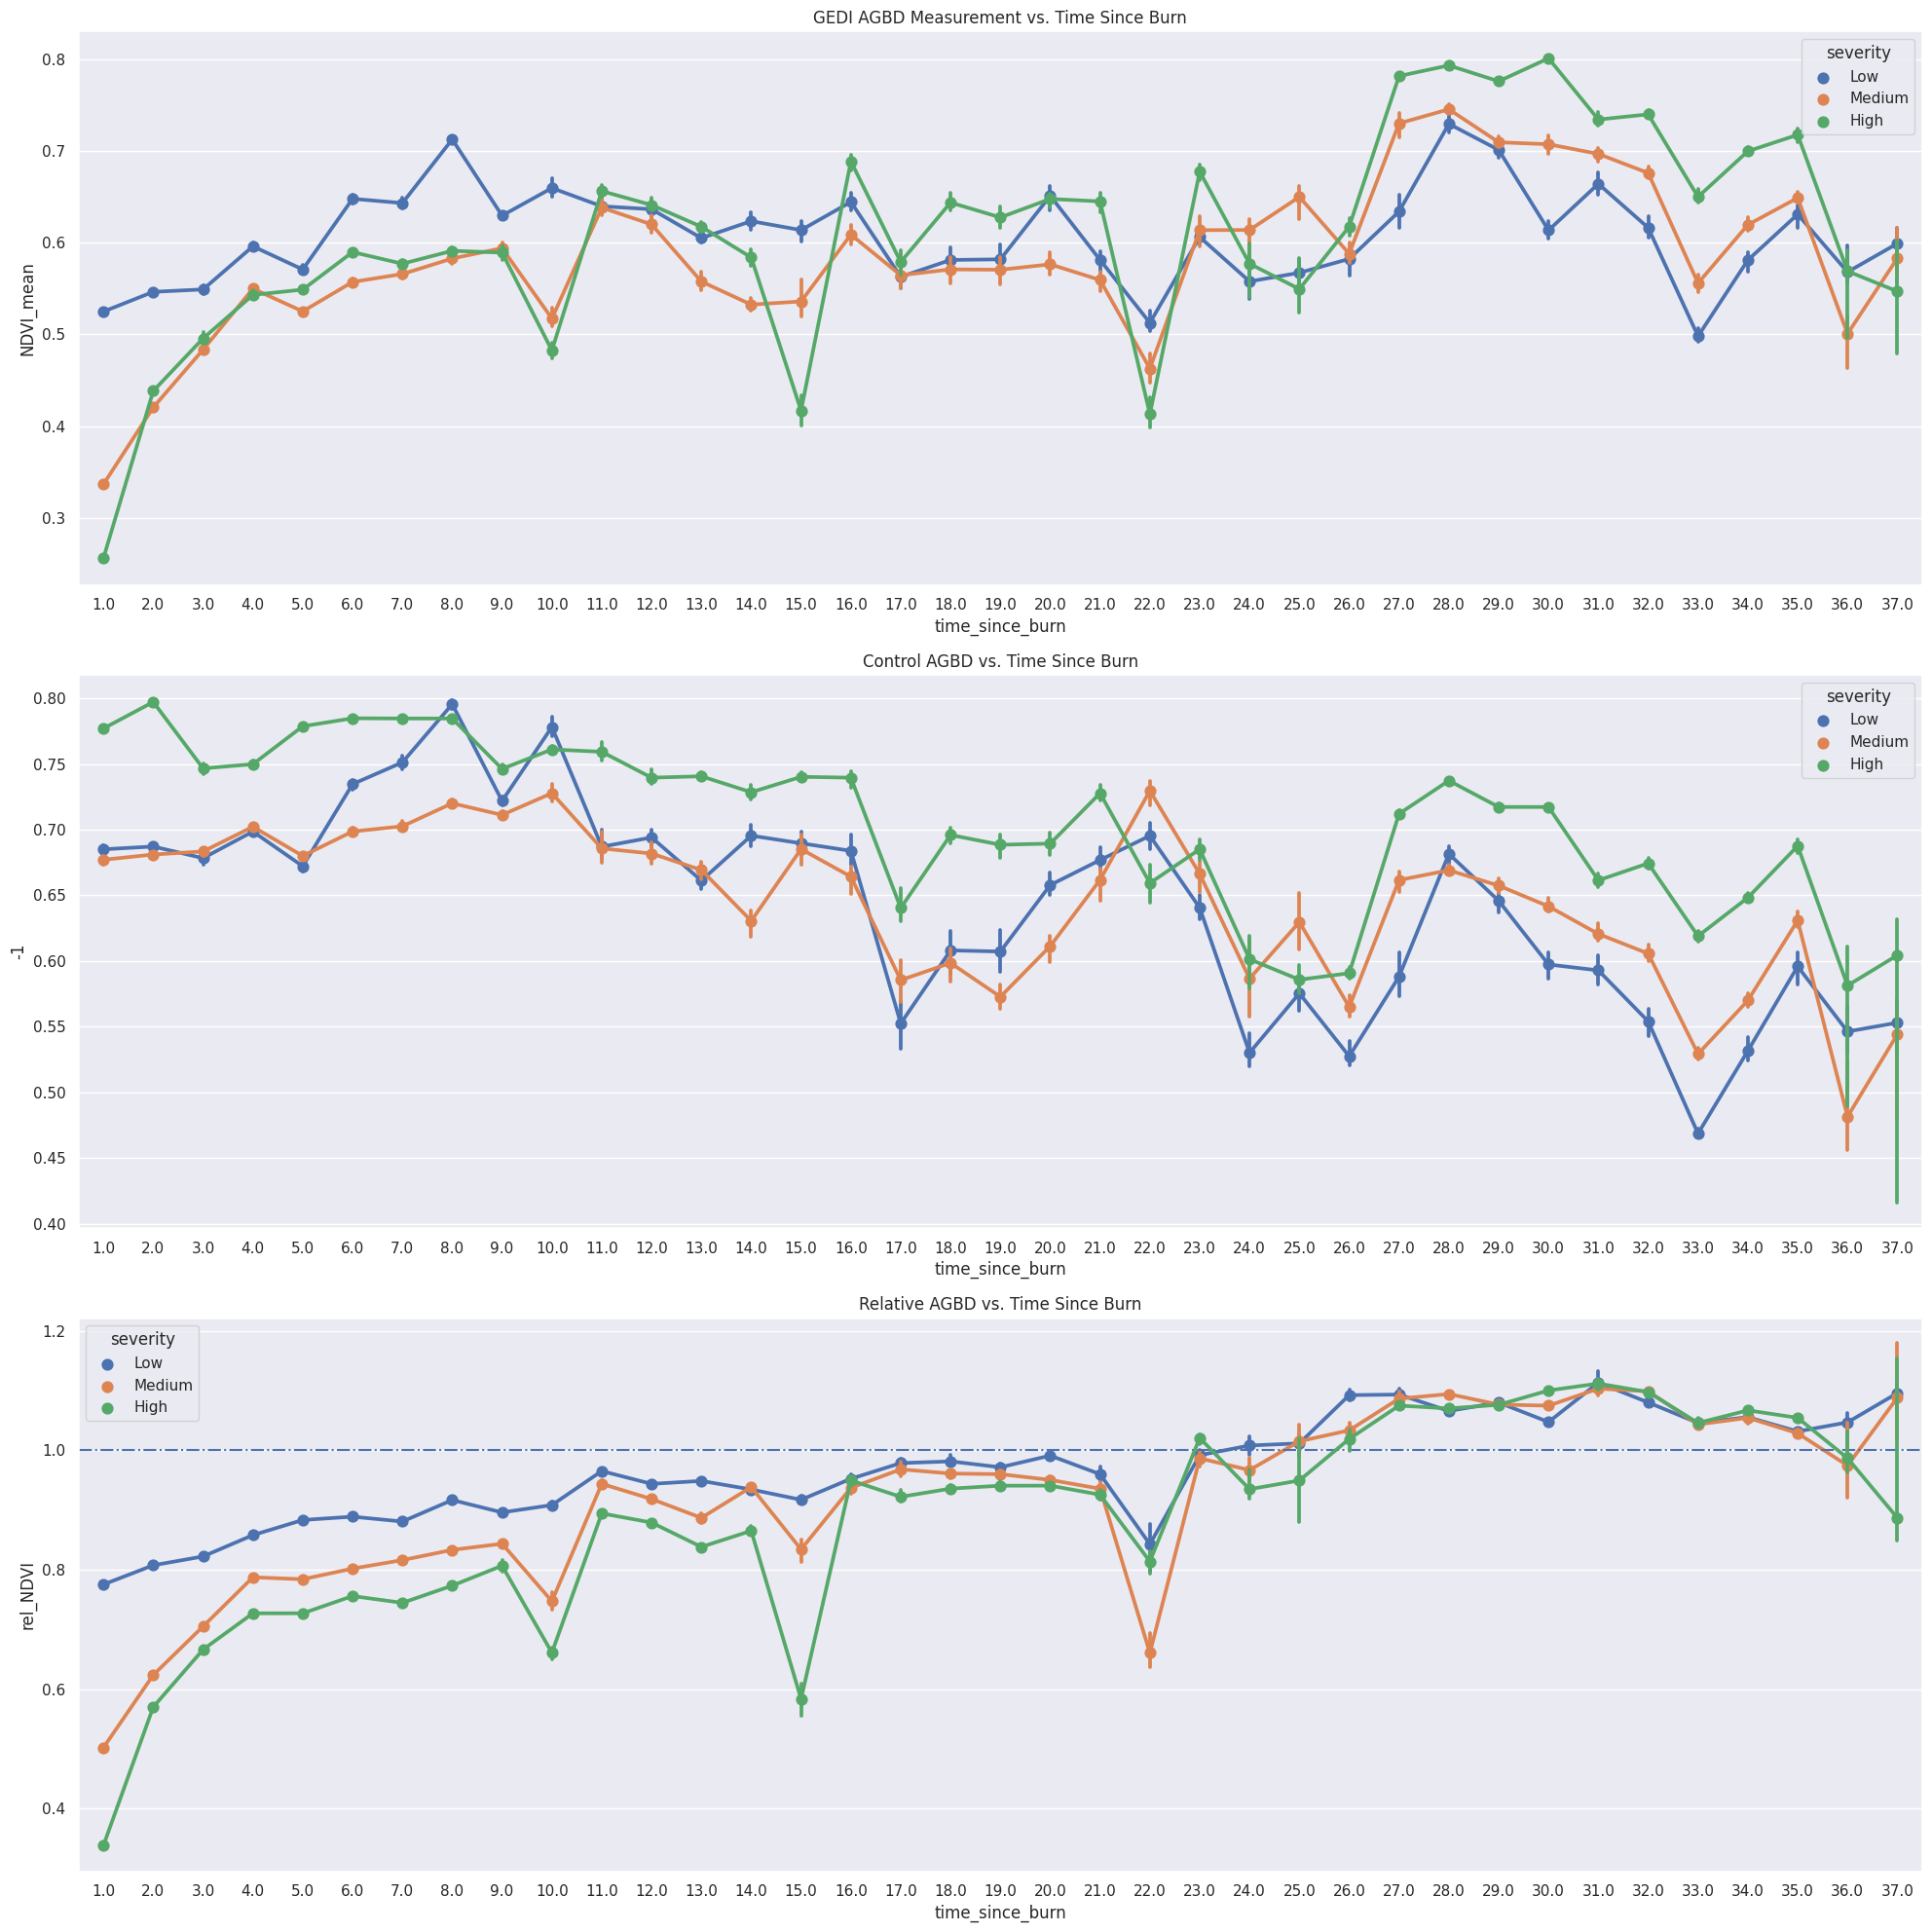

In [33]:
fig, ax = plt.subplots(3, 1, figsize=(20, 20))
sns.pointplot(gedi_ndvi, x='time_since_burn', y='NDVI_mean', hue='severity', estimator='median', ax=ax[0])
sns.pointplot(gedi_ndvi, x='time_since_burn', y='-1', hue='severity', estimator='median', ax=ax[1])
sns.pointplot(gedi_ndvi, x='time_since_burn', y='rel_NDVI', hue='severity', estimator='median', ax=ax[2])
ax[2].axhline(y=1, linestyle="-.")

ax[0].set_title("GEDI AGBD Measurement vs. Time Since Burn")
ax[1].set_title("Control AGBD vs. Time Since Burn")
ax[2].set_title("Relative AGBD vs. Time Since Burn")

#ax[2].set_ylim((0.5, 1.3))
fig.tight_layout()

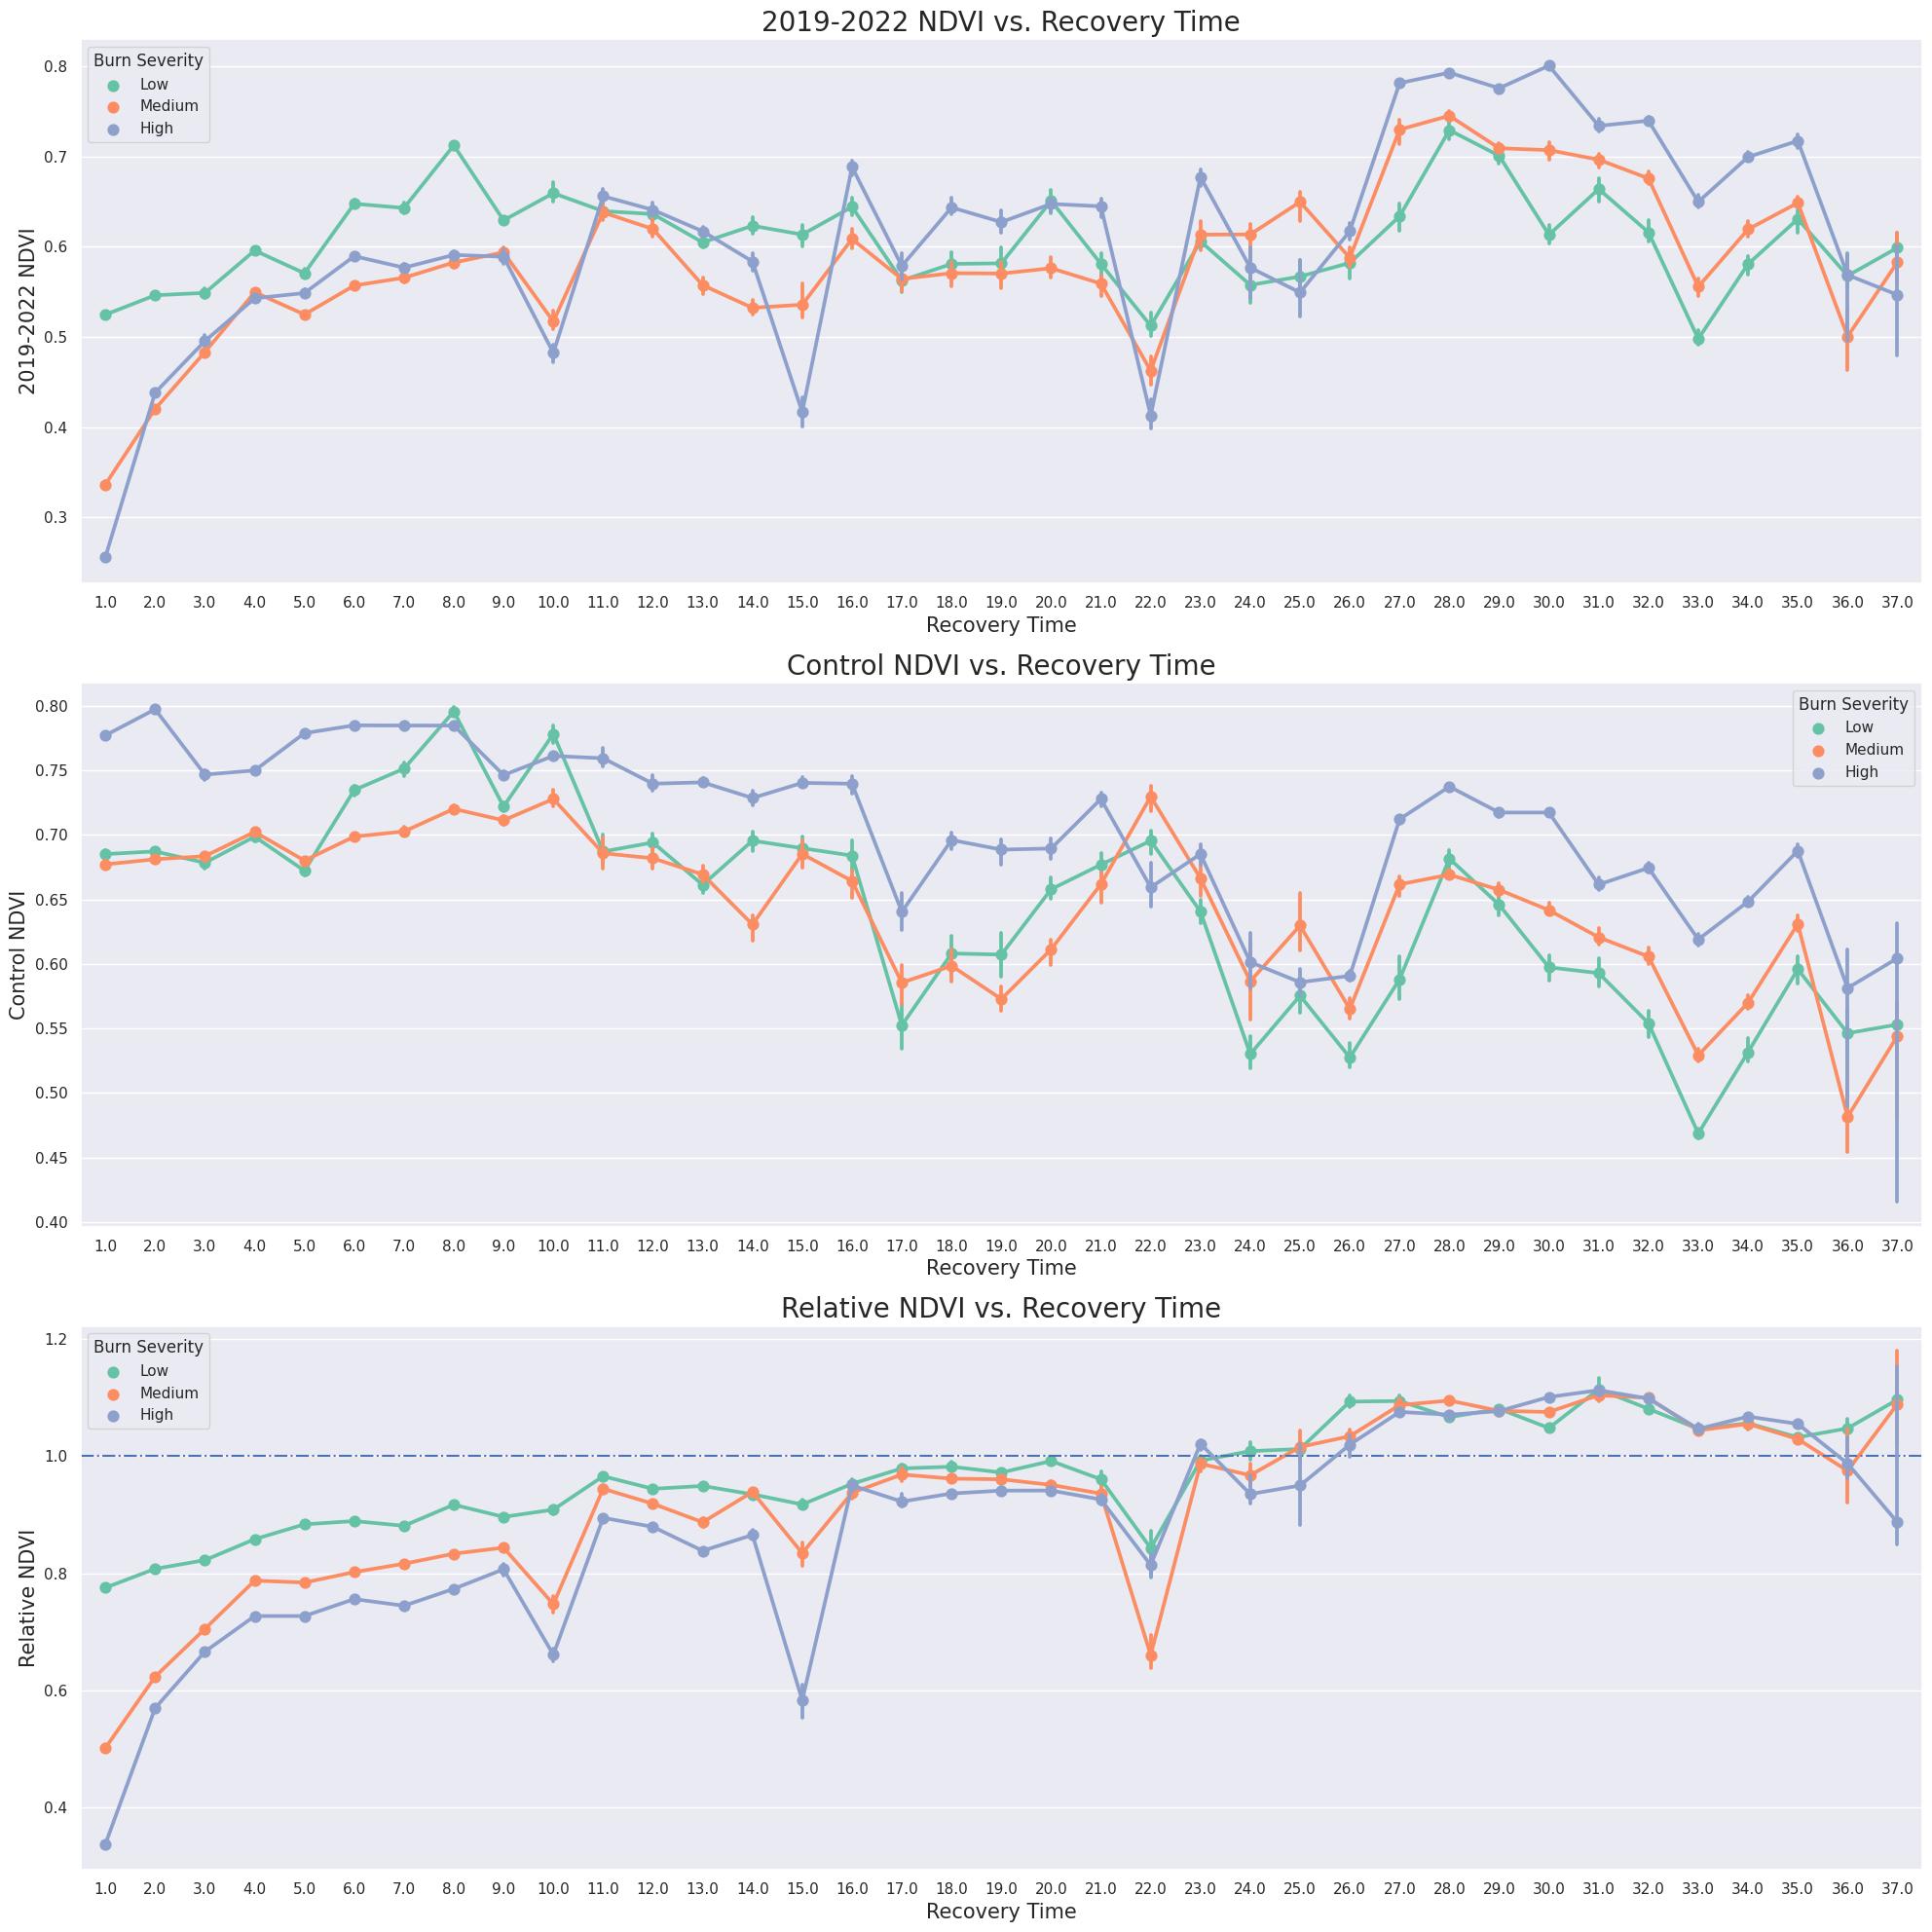

In [34]:
fig, ax = plt.subplots(3, 1, figsize=(20, 20))
sns.pointplot(gedi_ndvi, x='time_since_burn', y='NDVI_mean', hue='severity', estimator='median', ax=ax[0], palette="Set2")
sns.pointplot(gedi_ndvi, x='time_since_burn', y='-1', hue='severity', estimator='median', ax=ax[1], palette="Set2")
sns.pointplot(gedi_ndvi, x='time_since_burn', y='rel_NDVI', hue='severity', estimator='median', ax=ax[2], palette="Set2")
ax[2].axhline(y=1, linestyle="-.")

ax[0].set_title("2019-2022 NDVI vs. Recovery Time", fontsize=20)
ax[1].set_title("Control NDVI vs. Recovery Time", fontsize=20)
ax[2].set_title("Relative NDVI vs. Recovery Time", fontsize=20)

ax[0].legend(title='Burn Severity')
ax[1].legend(title='Burn Severity')
ax[2].legend(title='Burn Severity')

for i in range(3):
    ax[i].set_xlabel("Recovery Time", fontsize=20)

ax[0].set_ylabel("2019-2022 NDVI", fontsize=20)
ax[1].set_ylabel("Control NDVI", fontsize=20)
ax[2].set_ylabel("Relative NDVI", fontsize=20)


#ax[2].set_ylim((0.5, 1.3))
fig.tight_layout()

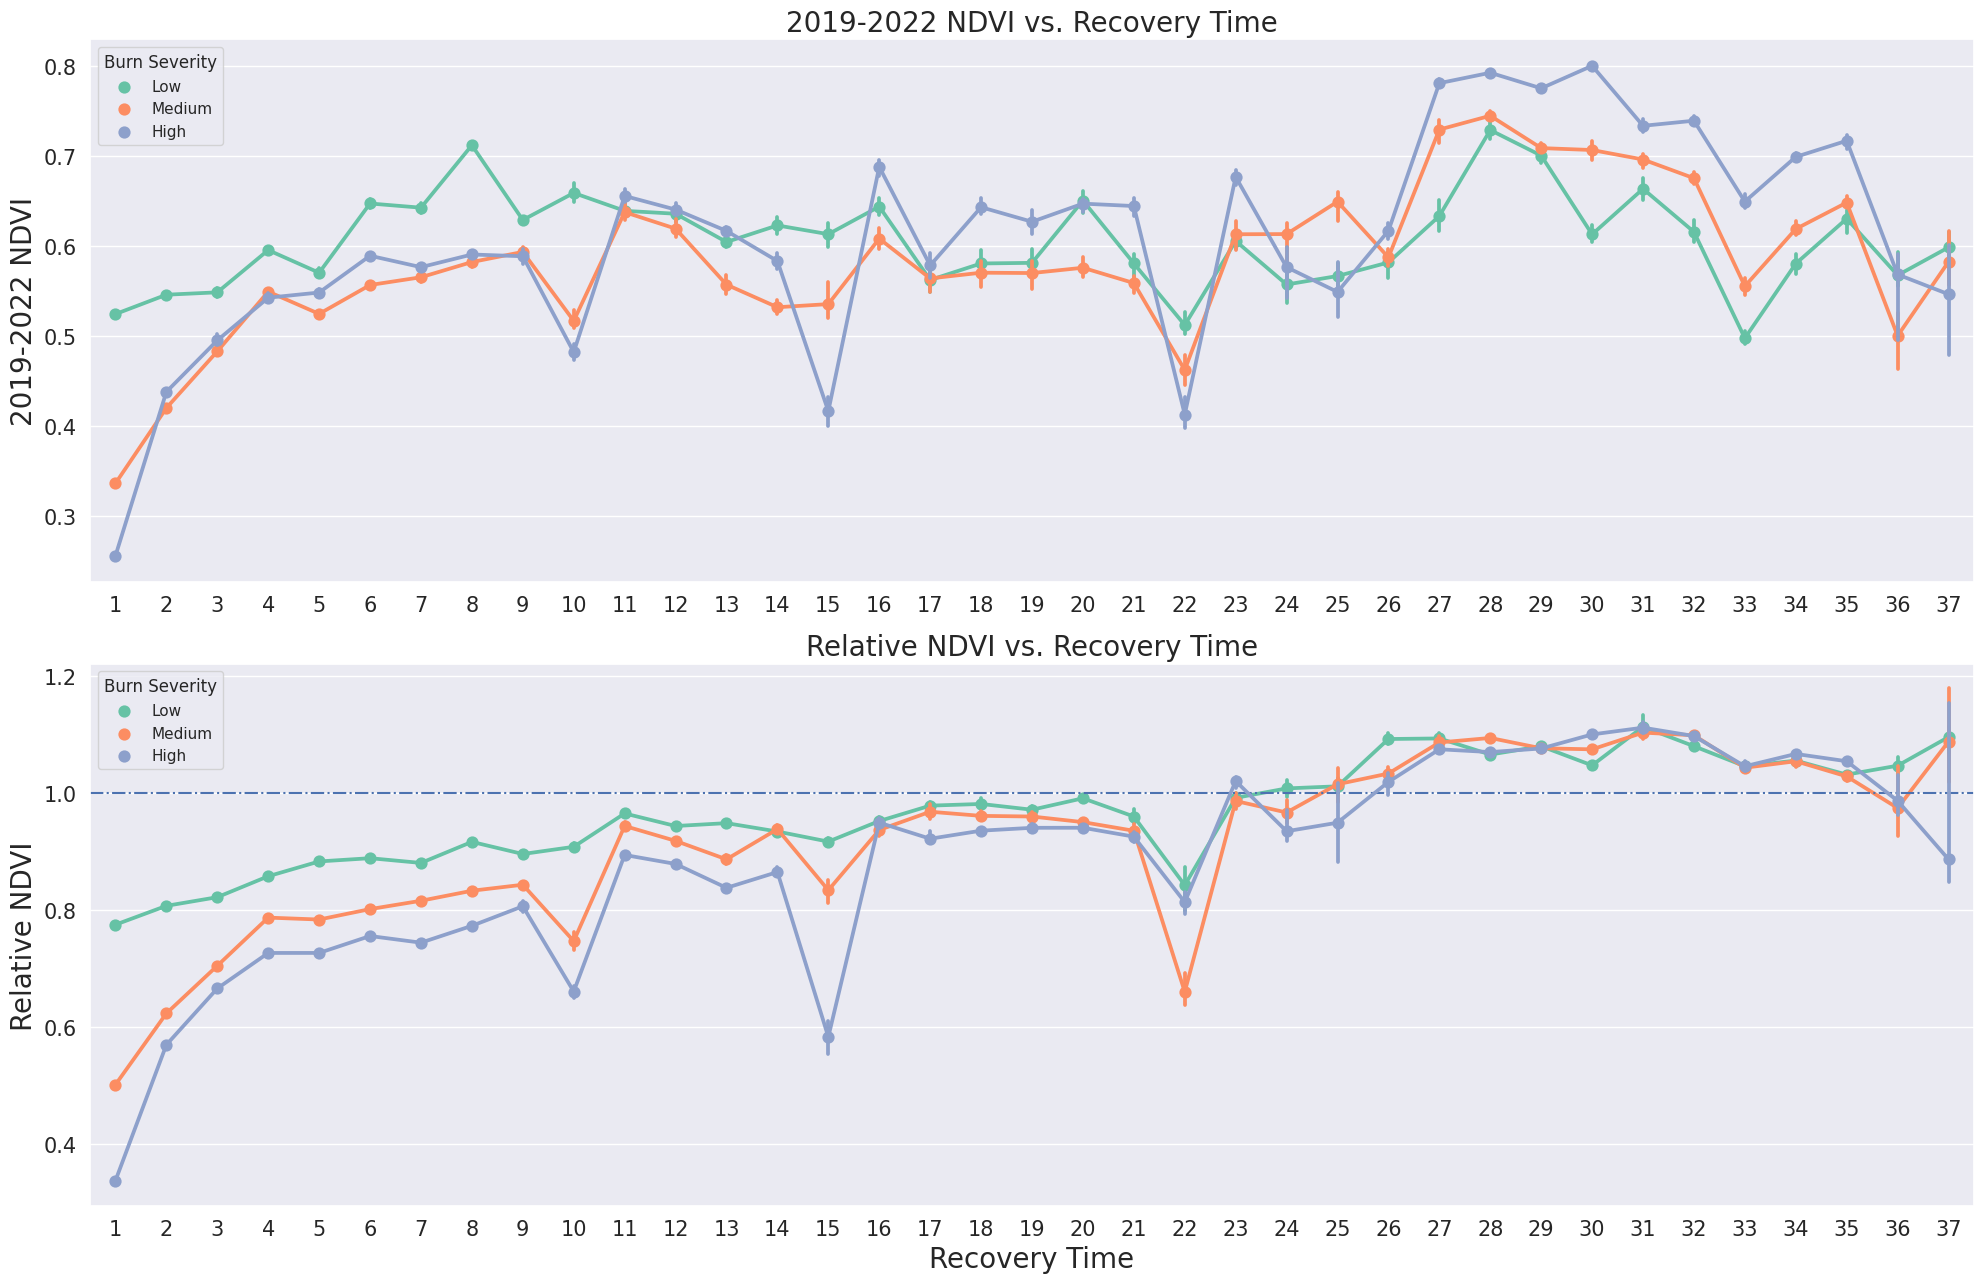

In [45]:
fig, ax = plt.subplots(2, 1, figsize=(20, 13))
sns.pointplot(gedi_ndvi, x='time_since_burn', y='NDVI_mean', hue='severity', estimator='median', ax=ax[0], palette="Set2")
sns.pointplot(gedi_ndvi, x='time_since_burn', y='rel_NDVI', hue='severity', estimator='median', ax=ax[1], palette="Set2")
ax[1].axhline(y=1, linestyle="-.")

ax[0].set_title("2019-2022 NDVI vs. Recovery Time", fontsize=20)
ax[1].set_title("Relative NDVI vs. Recovery Time", fontsize=20)

ax[0].legend(title='Burn Severity')
ax[1].legend(title='Burn Severity')
ax[0].set_xlabel("", fontsize=20)
ax[1].set_xlabel("Recovery Time", fontsize=20)

for i in range(2):
    ax[i].tick_params(axis='both', which='major', labelsize=15)

ax[0].set_ylabel("2019-2022 NDVI", fontsize=20)
ax[1].set_ylabel("Relative NDVI", fontsize=20)



#ax[2].set_ylim((0.5, 1.3))
fig.tight_layout()

### Space for time AGBD

In [21]:
gedi_ndvi.agbd_control, gedi_ndvi.rel_agbd

(0         104.655576
 1          85.143038
 4          73.914983
 5          77.864452
 7          94.562573
              ...    
 404823     41.570885
 404824     52.237296
 404825     93.333364
 404826     43.636295
 404827     45.752970
 Name: agbd_control, Length: 333021, dtype: float64,
 0         1.802088
 1         0.580755
 4         2.259743
 5         0.562684
 7         0.630209
             ...   
 404823    0.480612
 404824    0.398329
 404825    1.406967
 404826    0.729346
 404827    1.778824
 Name: rel_agbd, Length: 333021, dtype: float64)

(0.1, 1.25)

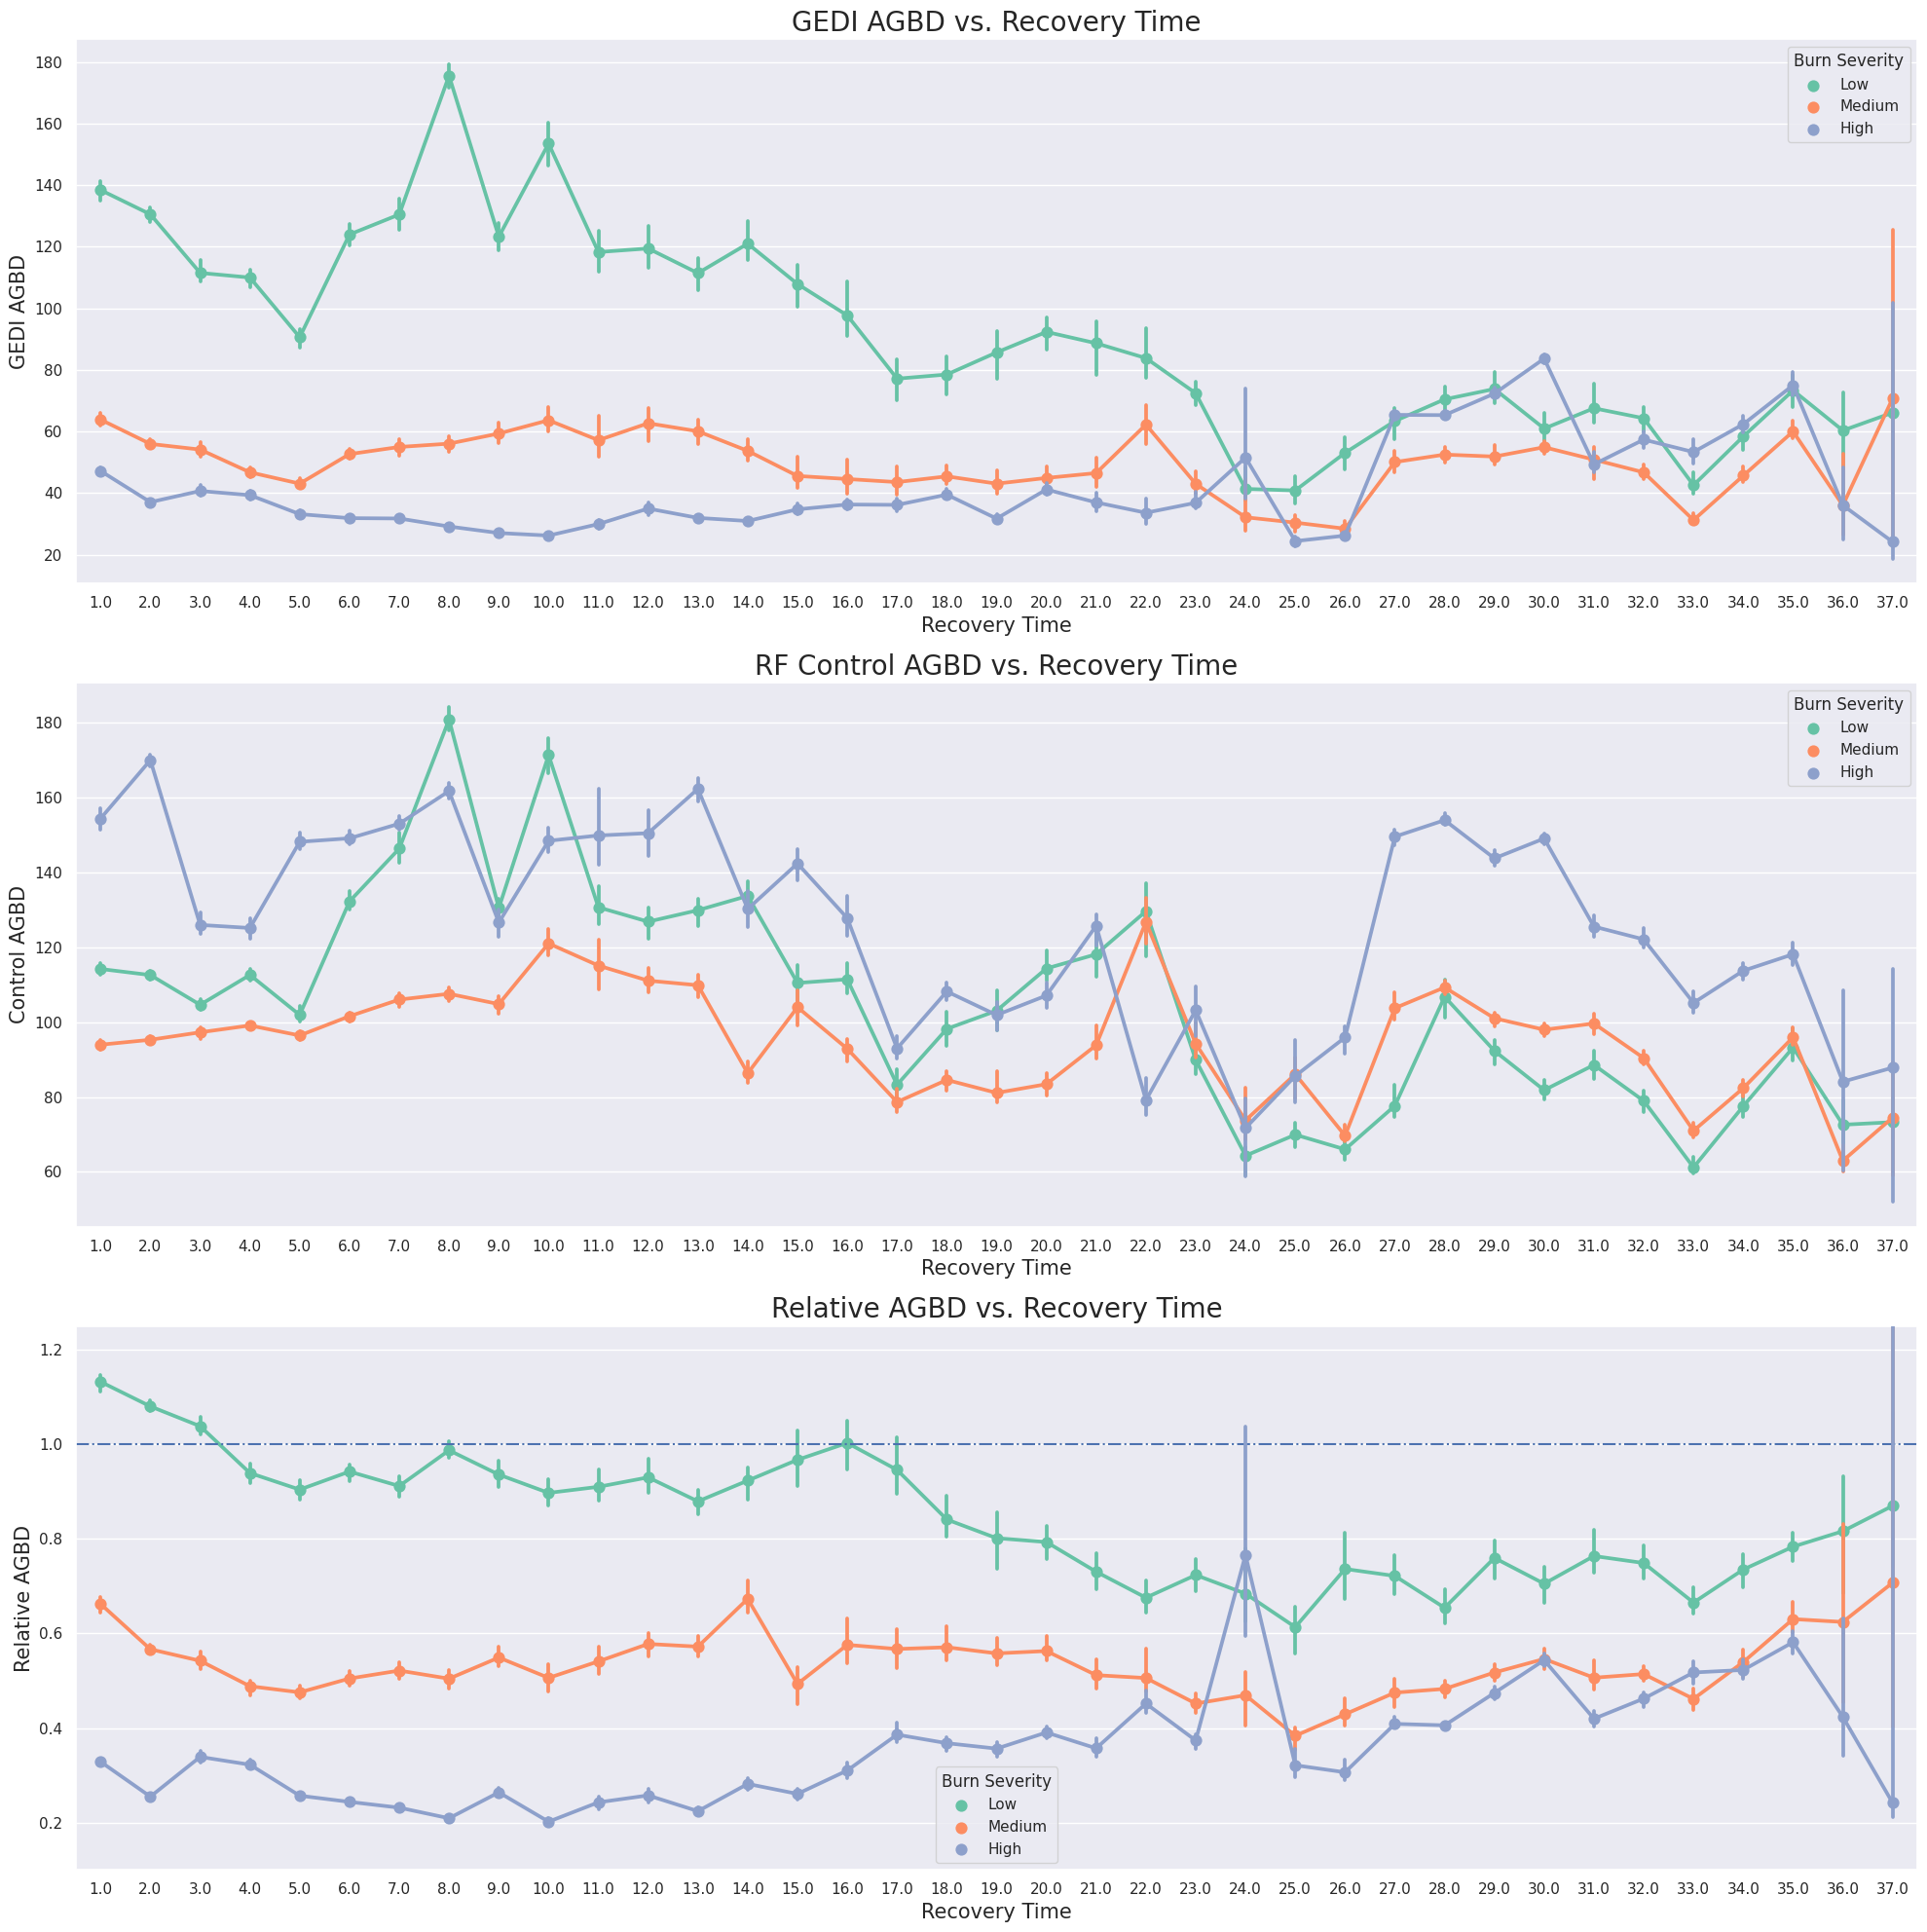

In [37]:
fig, ax = plt.subplots(3, 1, figsize=(20, 20))
sns.pointplot(gedi_ndvi, x='time_since_burn', y='agbd', hue='severity', estimator='median', ax=ax[0], palette="Set2")
sns.pointplot(gedi_ndvi, x='time_since_burn', y='agbd_control', hue='severity', estimator='median', ax=ax[1], palette="Set2")
sns.pointplot(gedi_ndvi, x='time_since_burn', y='rel_agbd', hue='severity', estimator='median', ax=ax[2], palette="Set2")
ax[2].axhline(y=1, linestyle="-.")

ax[0].set_title("GEDI AGBD vs. Recovery Time", fontsize=20)
ax[1].set_title("RF Control AGBD vs. Recovery Time", fontsize=20)
ax[2].set_title("Relative AGBD vs. Recovery Time", fontsize=20)

ax[0].legend(title='Burn Severity')
ax[1].legend(title='Burn Severity')
ax[2].legend(title='Burn Severity')

for i in range(3):
    ax[i].set_xlabel("Recovery Time", fontsize=15)

ax[0].set_ylabel("GEDI AGBD", fontsize=15)
ax[1].set_ylabel("Control AGBD", fontsize=15)
ax[2].set_ylabel("Relative AGBD", fontsize=15)


#ax[2].set_ylim((0.5, 1.3))
fig.tight_layout()
ax[2].set_ylim((0.1, 1.25))

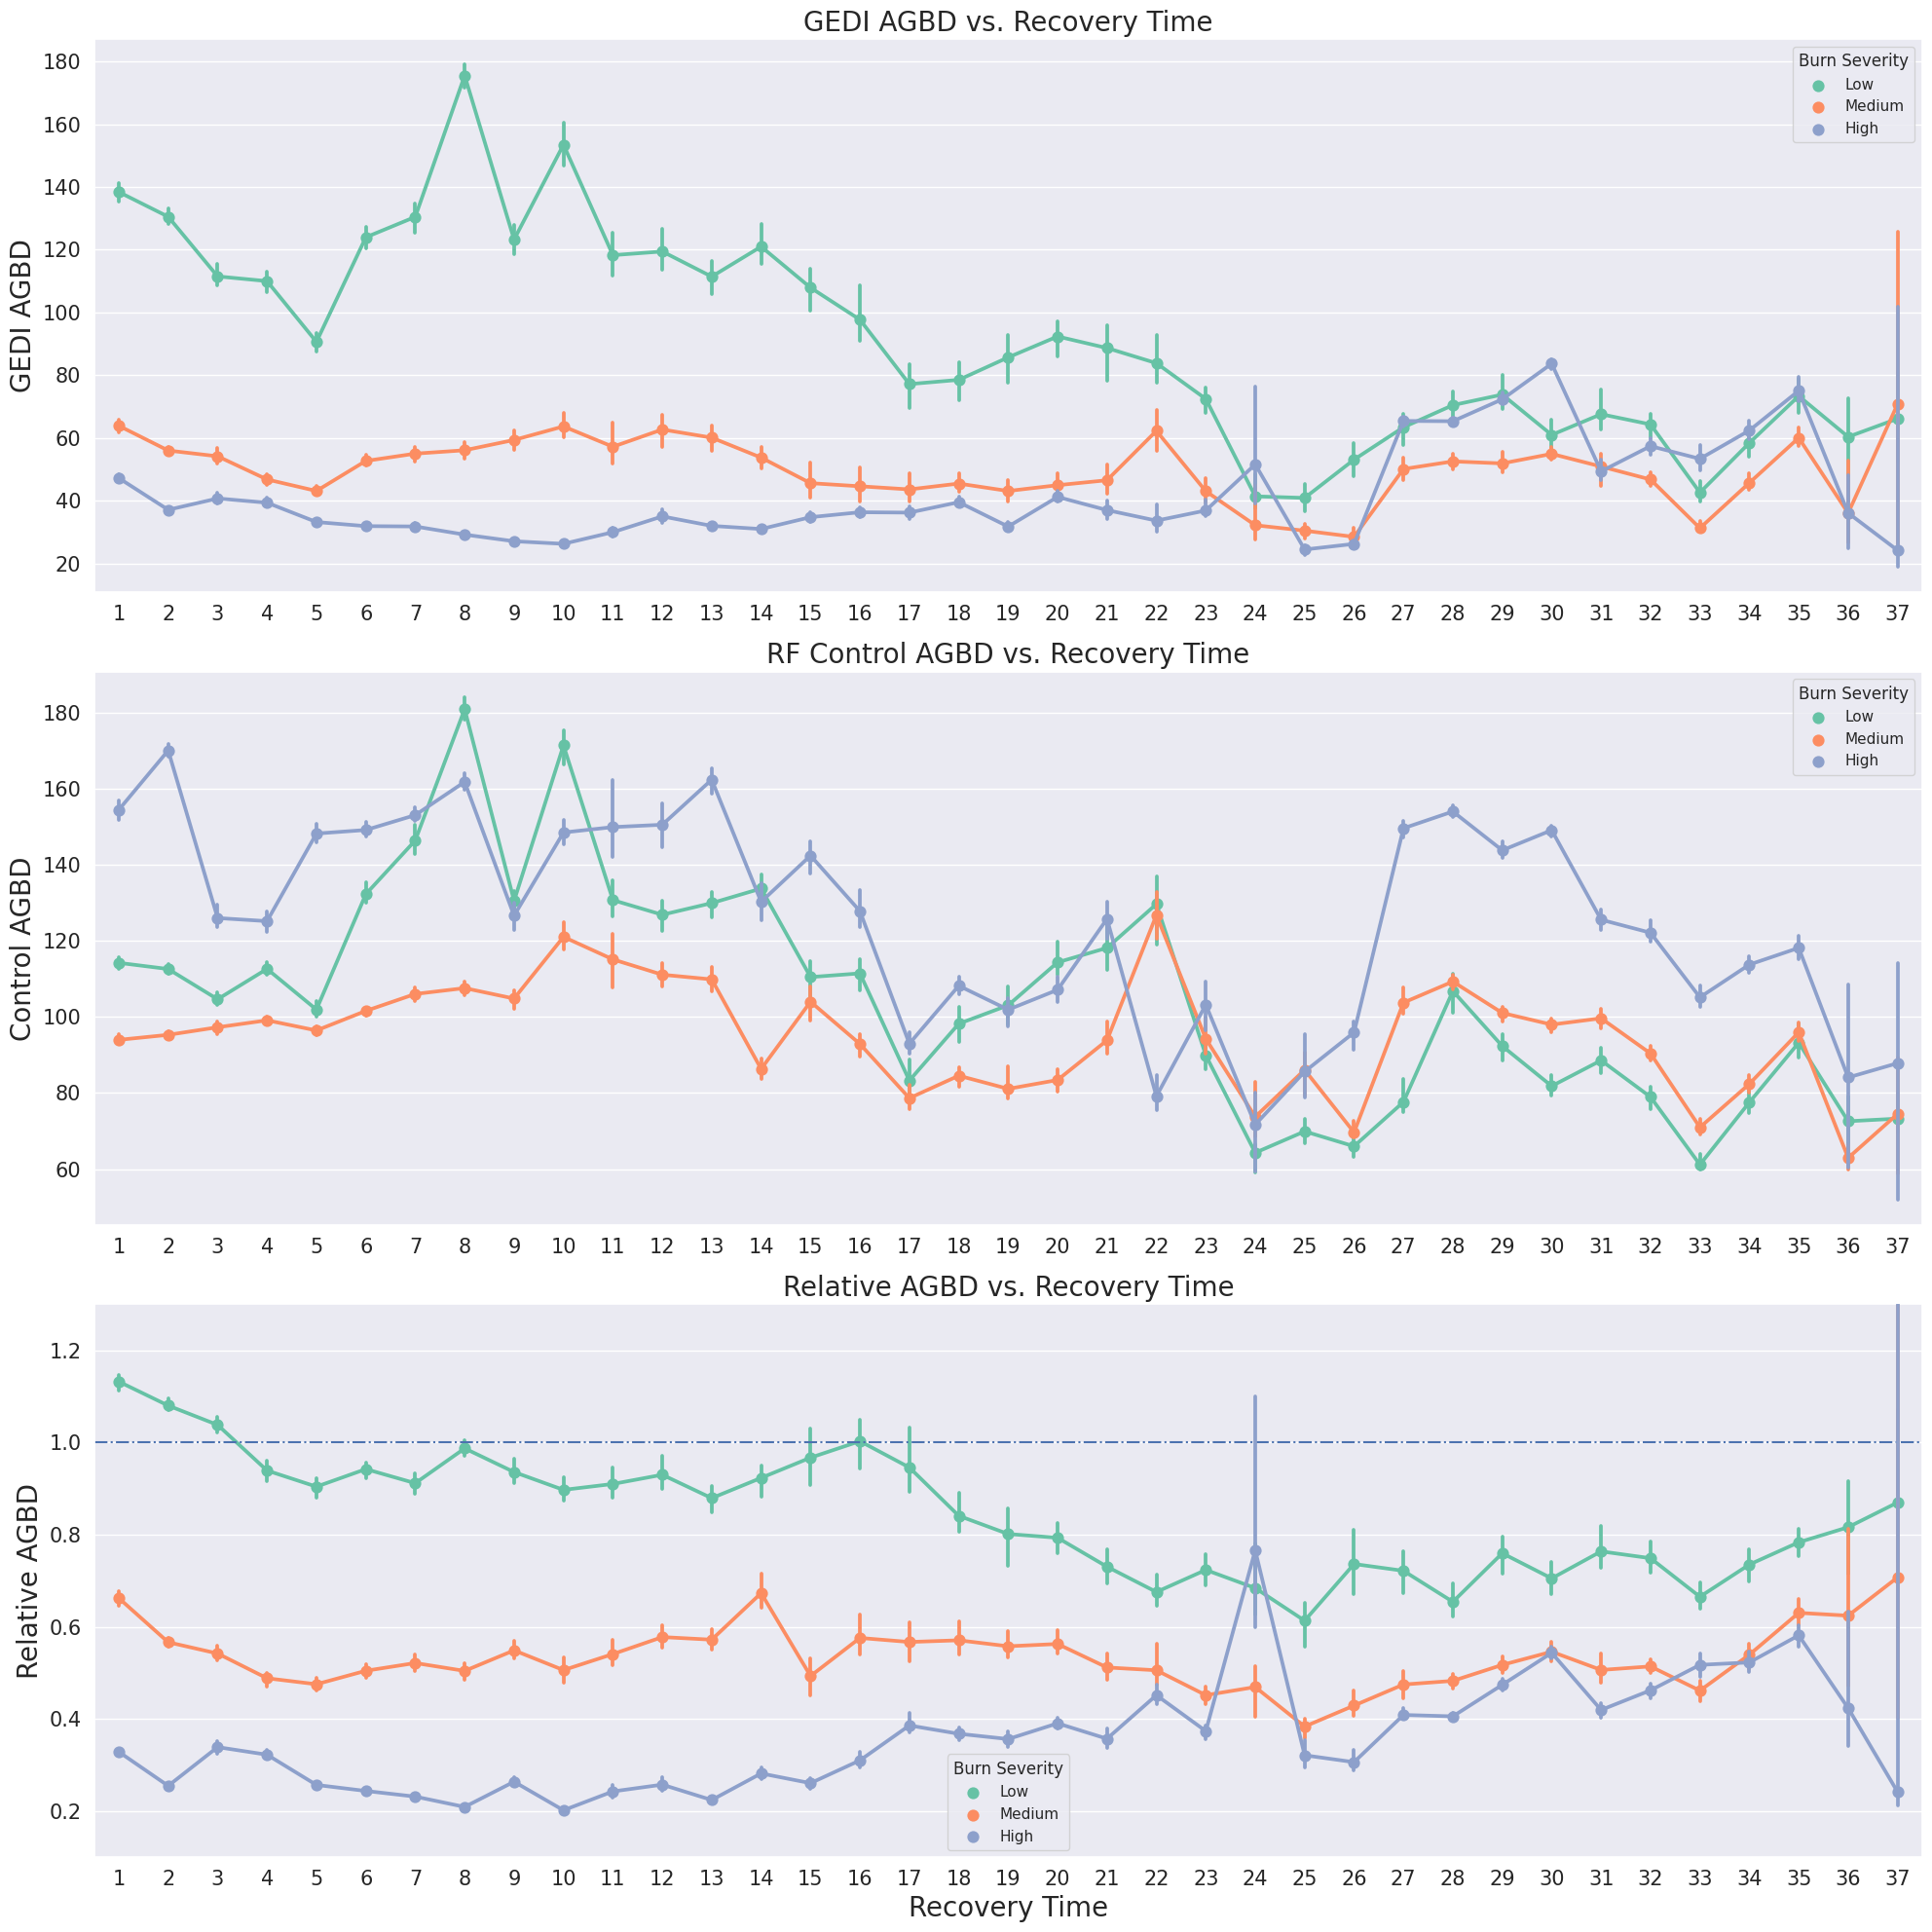

In [49]:
to_plot = gedi_ndvi.copy()
fig, ax = plt.subplots(3, 1, figsize=(20, 20))
sns.pointplot(to_plot, x='time_since_burn', y='agbd', hue='severity', estimator='median', ax=ax[0], palette="Set2")
sns.pointplot(to_plot, x='time_since_burn', y='agbd_control', hue='severity', estimator='median', ax=ax[1], palette="Set2")
sns.pointplot(to_plot, x='time_since_burn', y='rel_agbd', hue='severity', estimator='median', ax=ax[2], palette="Set2")
ax[2].axhline(y=1, linestyle="-.")

ax[0].set_title("GEDI AGBD vs. Recovery Time", fontsize=20)
ax[1].set_title("RF Control AGBD vs. Recovery Time", fontsize=20)
ax[2].set_title("Relative AGBD vs. Recovery Time", fontsize=20)

ax[0].legend(title='Burn Severity')
ax[1].legend(title='Burn Severity')
ax[2].legend(title='Burn Severity')

ax[0].set_xlabel("", fontsize=15)
ax[1].set_xlabel("", fontsize=15)
ax[2].set_xlabel("Recovery Time", fontsize=20)

for i in range(3):
    ax[i].tick_params(axis='both', which='major', labelsize=15)

ax[0].set_ylabel("GEDI AGBD", fontsize=20)
ax[1].set_ylabel("Control AGBD", fontsize=20)
ax[2].set_ylabel("Relative AGBD", fontsize=20)


ax[2].set_ylim((0.1, 1.3))
fig.tight_layout()

### Calculate Recovery Time

In [81]:
def calculate_recovery_time(x):
    for threshold in [50, 75, 90, 100]:
        for i in range(1, 33):
            threshold_val = threshold / 100.0
            val1 = x[f"{i}_rel"]
            val2 = x[f"{i+1}_rel"]
            if (val1 > threshold_val) and (val2 > threshold_val):
                x[f"{threshold}%_recovery"] = i
                break
    return x

gedi_ndvi_recovery = gedi_ndvi.apply(calculate_recovery_time, axis=1)